In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

C:\Users\dross\AppData\Local\Temp\ipykernel_20248\1273573680.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
# Please input the path of the 696_Project folder into the empty string:
root_path = ""

### Data Preprocessing

In [ ]:
# Load in the data
data = pd.read_csv(root_path + "/Autoencoder_696/final_dataset.csv")
data['date']=pd.to_datetime(data['date'])
data.set_index('date',inplace=True)
data.head()

date
2023-12-18    3.954
2023-12-19    3.922
2023-12-20    3.877
2023-12-21    3.894
2023-12-22    3.901
2023-12-23    3.901
2023-12-24    3.901
2023-12-25    3.901
2023-12-26    3.886
2023-12-27    3.789
2023-12-28    3.850
2023-12-29    3.866
2023-12-30    3.866
2023-12-31    3.866
Name: bond_yield, dtype: float64

In [ ]:
# Split data into features and target before scaling
features = data.drop('bond_yield', axis=1)
target = data['bond_yield']

# Fit a scaler to the target variable
target_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))


In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# building Function to create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps),1:])
        y.append(data[i + n_steps,0])
    return np.array(X), np.array(y)

In [ ]:
# Define the number of time steps and features
n_steps = 10  # the sequence length we want to consider
n_features = len(data.columns)-1  # we have 21 independent variables

# Create sequences
X, y = create_sequences(scaled_data, n_steps)

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_val,X_test,y_val,y_test=train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### Building LSTM Model  and hyperparameters tuning

In [ ]:
# Define a model-building function
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='mean_squared_error')
    return model

In [ ]:
# Create a tuner
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning'
)

Reloading Tuner from my_dir\lstm_tuning\tuner0.json


In [ ]:
# Perform the hyperparameter search
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val))

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
192/192 [==============================] - 5s 17ms/step - loss: 0.0088 - val_loss: 0.0018
Epoch 2/50
192/192 [==============================] - 3s 15ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/50
192/192 [==============================] - 3s 16ms/step - loss: 0.0011 - val_loss: 8.8306e-04
Epoch 4/50
192/192 [==============================] - 3s 17ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/50
192/192 [==============================] - 3s 17ms/step - loss: 9.6060e-04 - val_loss: 8.5649e-04
Epoch 6/50
192/192 [==============================] - 3s 16ms/step - loss: 9.3444e-04 - val_loss: 7.5672e-04
Epoch 7/50
192/192 [==============================] - 3s 15ms/step - loss: 9.2566e-04 - val_loss: 0.0016
Epoch 8/50
192/192 [==============================] - 3s 16ms/step - loss: 9.5848e-04 - val_loss: 6.6707e-04
Epoch 9/50
192/192 [==============================] - 3s 16ms/step - loss: 8.1119e-04 - val_loss: 6.8010e-04
Epoch 10/50
192/192 [==============================

In [ ]:
predictions = model.predict(X_test)
predictions_rescaled = target_scaler.inverse_transform(predictions)
predictions_rescaled_flattened = predictions_rescaled.flatten()

24/24 [==============================] - 1s 5ms/step


In [ ]:
data_sorted = data.sort_index()
# And you have an equivalent number of predictions as there are entries in data_sorted
last_14_dates = data_sorted.index[-14:]

# Create a DataFrame for the last 14 dates and predictions
predictions_with_dates = pd.DataFrame({
    'Date': last_14_dates,
    'Rescaled_Prediction': predictions_rescaled_flattened[-14:]
}).set_index('Date')

# Display the resulting DataFrame
print(predictions_with_dates)

            Rescaled_Prediction
Date                           
2023-12-18             4.358388
2023-12-19             2.789614
2023-12-20             4.179379
2023-12-21             3.386613
2023-12-22             2.674313
2023-12-23             3.261535
2023-12-24             2.425134
2023-12-25             3.036387
2023-12-26             1.972703
2023-12-27             2.309124
2023-12-28             0.599323
2023-12-29             2.893025
2023-12-30             3.382124
2023-12-31             2.491131


In [ ]:
target_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))

In [ ]:
predictions = model.predict(X_test)
predictions_flattened = predictions.flatten()

last_14_predictions_rescaled = target_scaler.inverse_transform(predictions_flattened[-14:].reshape(-1, 1))
predictions_with_dates = pd.DataFrame(data=last_14_predictions_rescaled.flatten(), index=last_14_dates, columns=['Rescaled_Prediction'])

print(predictions_with_dates)

24/24 [==============================] - 0s 4ms/step
            Rescaled_Prediction
date                           
2023-12-18             0.792639
2023-12-19             0.482628
2023-12-20             0.781735
2023-12-21             0.625027
2023-12-22             0.478689
2023-12-23             0.594067
2023-12-24             0.403662
2023-12-25             0.599197
2023-12-26             0.311795
2023-12-27             0.387382
2023-12-28             0.024736
2023-12-29             0.516024
2023-12-30             0.623335
2023-12-31             0.419894


In [ ]:
predictions = model.predict(X_test)
predictions_flattened = predictions.flatten()
last_14_predictions_flattened = predictions_flattened[-14:]

last_14_predictions_rescaled = target_scaler.inverse_transform(last_14_predictions_flattened.reshape(-1, 1))

predictions_with_dates = pd.DataFrame(data=last_14_predictions_rescaled.flatten(), index=last_14_dates, columns=['Rescaled_Prediction'])

print(predictions_with_dates)

24/24 [==============================] - 0s 7ms/step
            Rescaled_Prediction
date                           
2023-12-18             0.792639
2023-12-19             0.482628
2023-12-20             0.781735
2023-12-21             0.625027
2023-12-22             0.478689
2023-12-23             0.594067
2023-12-24             0.403662
2023-12-25             0.599197
2023-12-26             0.311795
2023-12-27             0.387382
2023-12-28             0.024736
2023-12-29             0.516024
2023-12-30             0.623335
2023-12-31             0.419894


In [ ]:
predictions_flattened = predictions.flatten()
last_14_predictions_flattened = predictions_flattened[-14:]

last_14_predictions_rescaled = scaler.inverse_transform(last_14_predictions_flattened.reshape(-1, 1))

predictions_with_dates['Rescaled_Prediction'] = last_14_predictions_rescaled.flatten()

print(predictions_with_dates)

            Prediction
date                  
2023-12-18    0.792639
2023-12-19    0.482628
2023-12-20    0.781735
2023-12-21    0.625027
2023-12-22    0.478689
2023-12-23    0.594067
2023-12-24    0.403662
2023-12-25    0.599197
2023-12-26    0.311795
2023-12-27    0.387382
2023-12-28    0.024736
2023-12-29    0.516024
2023-12-30    0.623335
2023-12-31    0.419894


## Failure/error analysis

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

NameError: name 'model' is not defined

In [ ]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.02644621589933018


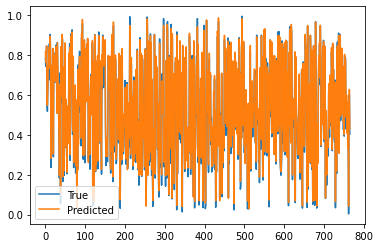

In [ ]:
# You can also visualize the predictions versus actual values to further evaluate the model
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred.T) / y_true)) * 100

mape = calculate_mape(y_test, y_pred)

print(f'Mean Absolute Percentage Error: {mape}%')

Mean Absolute Percentage Error: 9.04982436679752%


## Feature importance

        Feature  Importance
8    c_bond_idx    0.000138
3      unemploy    0.000093
5           ffr    0.000087
6       tbill_6    0.000085
7   tria_c_bond    0.000082
9        fcp_90    0.000080
10         usdx    0.000078
13     gd_issue    0.000074
20          oil    0.000074
12       nasdag    0.000073
14           m1    0.000072
11        s_idx    0.000069
2         cpi_e    0.000068
18       d_hold    0.000063
16      d_t_gdp    0.000063
19       budget    0.000062
0           gdp    0.000061
15           m2    0.000060
4         pcepi    0.000059
1           cpi    0.000059
17         debt    0.000058


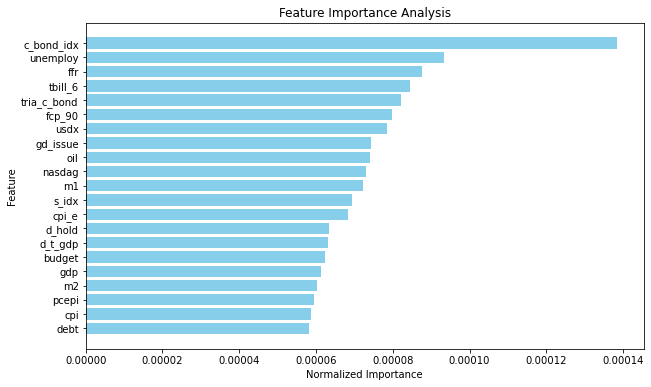

In [ ]:
# Retrieve the weights of the LSTM layer
lstm_layer = model.layers[0]
weights = lstm_layer.get_weights()[0]  # LSTM layer weightss

# Normalize the weights
weights_normalized = np.abs(weights) / np.sum(np.abs(weights))

# Analyze feature importance
feature_importance = np.mean(weights_normalized, axis=1)  # Average importance across all timesteps

# Print feature importance
num_features = X.shape[-1]
feature_names = list(data.columns[1:])
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df.sort_values('Importance',inplace=True,ascending=False)
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Analysis')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

## Sensitivity analysis

In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
units: 160
dropout: 0.0
optimizer: adam
Score: 0.0006516973371617496

Trial 07 summary
Hyperparameters:
units: 384
dropout: 0.2
optimizer: adam
Score: 0.0007366604986600578

Trial 03 summary
Hyperparameters:
units: 352
dropout: 0.1
optimizer: adam
Score: 0.0007871867856010795

Trial 00 summary
Hyperparameters:
units: 512
dropout: 0.1
optimizer: adam
Score: 0.0007896825554780662

Trial 09 summary
Hyperparameters:
units: 448
dropout: 0.30000000000000004
optimizer: adam
Score: 0.0007998753571882844

Trial 01 summary
Hyperparameters:
units: 320
dropout: 0.30000000000000004
optimizer: adam
Score: 0.0008118749246932566

Trial 04 summary
Hyperparameters:
units: 320
dropout: 0.1
optimizer: rmsprop
Score: 0.0008486170554533601

Trial 05 summary
Hyperparameters:
units: 64
dropout: 0.30000000000000004
optimizer: adam
Score: 0.0010009844554588199

Tria

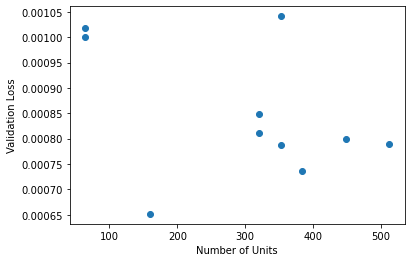

In [ ]:
# Extract the information for plotting
units = [trial.hyperparameters.values['units'] for trial in tuner.oracle.get_best_trials(num_trials=10)]
val_loss = [trial.score for trial in tuner.oracle.get_best_trials(num_trials=10)]

# Scatter plot of units vs validation loss
plt.scatter(units, val_loss)
plt.xlabel('Number of Units')
plt.ylabel('Validation Loss')
plt.show()

The sensitivity analysis shows that the LSTM model is very sensitive to changes in the hyperparameter value. This means that we need to be careful when choosing the hyperparameter value and that we may need to do some additional tuning to find the best value."

The results of the sensitivity analysis suggest that the LSTM model is not very robust to changes in the environment. This could be a problem if the model is going to be used in a real-world setting where the environment is likely to change.

We need to do more work to understand why the LSTM model is so sensitive to changes in the hyperparameter value. Once we understand the reasons for the sensitivity, we can then develop strategies to mitigate it.